this notebook does some spot checking on learned weight patterns in `scripts/training/imagenet_val/feature_approximation/local_pcn_original_imagenet/submit_sep2.py`.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from thesis_v2 import dir_dict
from thesis_v2.training.training_aux import load_training_results

In [3]:
from sys import path
from os.path import join, exists, dirname
from os import makedirs



In [4]:
folder_to_check = 'scripts/training/imagenet_val/feature_approximation/local_pcn_original_imagenet'
path.insert(0, join(dir_dict['root'], folder_to_check))
from submit_sep2 import param_iterator

In [5]:
from numpy.linalg import norm
import numpy as np

In [6]:
from sklearn.decomposition import PCA
from pickle import dump

In [7]:


def calc_raw_stats(weight_matrix):
    # weight_matrix is N * D
    # N = number of filters
    # D = size of a (flattened) filter.
    mean_all = weight_matrix.mean(axis=1)
    std_all = weight_matrix.std(axis=1)
    print('mean_all', mean_all.mean(), mean_all.std())
    print('std_all', std_all.mean(), std_all.std())
    
def calc_normed_pca(weight_matrix, verbose=False):
    # here `normed` means PCA after normalization of weight_matrix
    
    # there are multiple ways to define `normalization`
    # 
    # a simple way is to make each flattened filter with unit norm.
    weight_matrix_norm = norm(weight_matrix, axis=1, keepdims=True)
#     assert weight_matrix_norm.shape == (256,1)
    weight_matrix_normed = weight_matrix/weight_matrix_norm
    
    # tested, works as expected.
    if verbose:
        assert np.allclose(norm(weight_matrix_normed, axis=1), 1.0)
    
    
    # then let's do PCA
    pca_obj = PCA(svd_solver='full')
    pca_obj.fit(weight_matrix_normed)
    if verbose:
        # top 10 explains 60%;
        # top 20 explains 85%;
        # looks fine to me, compared to https://doi.org/10.1101/677237
        # "Recurrent networks can recycle neural resources to flexibly trade speed for accuracy in visual recognition"
        
        print(np.cumsum(pca_obj.explained_variance_ratio_)[:20])
        print(pca_obj.components_.shape)
    
    # then let's return and save them.
    return {
        'weight_matrix_norm': weight_matrix_norm,
        'weight_matrix': weight_matrix,
        'components': pca_obj.components_,
        'explained_variance_ratio': pca_obj.explained_variance_ratio_,
    }

def construct_back_by_interleave(x1, x2, by1, by2):
    n1, m1 = x1.shape
    n2, m2 = x2.shape
    assert n1 % by1 == 0
    assert n2 % by2 == 0
    assert m1==m2 and n1//by1 == n2//by2
    
    x1 = x1.reshape(n1//by1, by1, m1)
    x2 = x2.reshape(n2//by2, by2, m2)
    return np.concatenate((x1,x2), axis=1).reshape((n1+n2, m1))


def save_one_result(filename, data):
    makedirs(dirname(filename), exist_ok=True)
    with open(filename, 'wb') as f:
        dump(data, f)

In [8]:
# create dir
global_vars = {
    'save_dir': join(dir_dict['analyses'],
                     'scripts+imagenet_val+feature_approximation_lpcn_original_sep2',
                    'pca')
}

def prepare_dir():
    save_dir = global_vars['save_dir']
    if not exists(save_dir):
        makedirs(save_dir)
prepare_dir()

In [9]:
def collect_all():
    save_dir = global_vars['save_dir']
    count = 0
    verbose = True
    for idx, data in enumerate(param_iterator()):
        count += 1        
        
        key = data['key_this_original']
        if data['param_dict_actual']['basemodel_idx'] in (1,2):
            # seems too much memory and jobs crashed on mind. not available.
            continue
        
        
        def filename_gen(x):
            return join(save_dir, f'{idx}/unit_norm', f'{x}.pkl')
        
        filename_set = {'ff', 'lateral', 'all'}
        if all([exists(filename_gen(x)) for x in filename_set]):
            # right now if partially done, the partial results will be fully overwritten.
            continue
        # then load weights.
        result = load_training_results(key, return_model=False, return_checkpoint=True)
        # load loss curve to make sure we are good in approximation.
        
        
        loss_curves = sum([ [y['train'] for y in x] for x in result['stats_all']], [])
        print(len(loss_curves))
        
        # plot the curve
        plt.close('all')
        plt.figure(figsize=(10, 3))
        plt.plot(loss_curves)
        plt.show()
        
        # use float64 for all analysis to retain precision.
        weight_np = result['checkpoint']['model']['moduledict.conv0.weight'].numpy().astype(np.float64)
#         print(weight_np.dtype)
#         print(weight_np.shape)
#         channel_shape_all = (16, 32)
#         assert len(weight_np.shape)==4 and weight_np.shape[:2] == channel_shape_all
        
        kernel_shape = weight_np.shape[2:]
#         channel_shape = (16, 16)
        channel_shape_all = weight_np.shape[:2]
        channel_high = weight_np.shape[0]
        channel_low = weight_np.shape[1] - weight_np.shape[0]
        
        
        assert kernel_shape in {(9,9)}
        kernel_numel = kernel_shape[0]*kernel_shape[1]
        weight_np_ff = weight_np[:,:channel_low]
        weight_np_lateral = weight_np[:,channel_low:]
        assert weight_np_ff.shape == (channel_high, channel_low) + kernel_shape
        assert weight_np_lateral.shape == (channel_high, channel_high) + kernel_shape
        
        weight_np_ff = weight_np_ff.reshape((channel_low*channel_high, kernel_shape[0]*kernel_shape[1]))
        weight_np_lateral = weight_np_lateral.reshape((channel_high*channel_high, kernel_shape[0]*kernel_shape[1]))
        
        new_shape_all = (channel_high*(channel_high+channel_low), kernel_shape[0]*kernel_shape[1])
        
        weight_np_all = weight_np.reshape(new_shape_all)
        
        
        weight_np_all_debug = construct_back_by_interleave(weight_np_ff, weight_np_lateral, by1=channel_low,by2=channel_high)
        
        
        
#         print(weight_np_all_debug.shape)
        assert np.array_equal(
            weight_np_all,
            weight_np_all_debug,
        )
#         print(weight_np_lateral.shape, weight_np_ff.shape)
        
        if verbose:
            print('idx', idx)
            print('key', key)
            # show some raw stats.
            calc_raw_stats(weight_np_ff)
            calc_raw_stats(weight_np_lateral)
            calc_raw_stats(weight_np_all)

        pca_res_dict = dict()
        pca_res_dict['ff'] = calc_normed_pca(weight_np_ff, verbose)
        pca_res_dict['lateral'] = calc_normed_pca(weight_np_lateral, verbose)
        pca_res_dict['all'] = calc_normed_pca(weight_np_all, verbose)
        
        # simply store it as pickle, for simplicity.
        
#         data_to_save = {
#             'idx': idx,
#             'key': key,
#             'ff': pca_res_ff,
#             'lateral': pca_res_lateral,
#             'all': pca_res_all,
#         }
        
        # then save.
        # I think it's good to save as `idx/unit_norm/ff|lateral|all/data.pkl`;
        # this way, I can extend as needed.
        
        for fn in filename_set:
            save_one_result(filename_gen(fn), pca_res_dict[fn])
        
    print(count)


7000


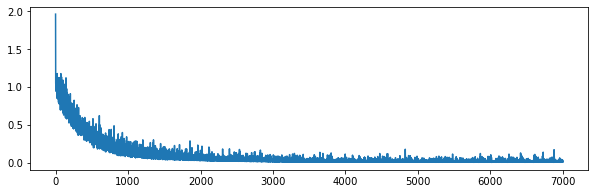

idx 0
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx0/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0014251232634690859 0.02296429446863572
std_all 0.07469353391544231 0.09550824327579595
mean_all 5.598569480863734e-05 0.010878884656604085
std_all 0.030590361744298335 0.013468632618840928
mean_all 0.0007405544791388618 0.01798118767844421
std_all 0.05264194782987032 0.07167905376059562
[0.26902227 0.3777577  0.45848392 0.52655012 0.56440439 0.59999049
 0.63484185 0.66534808 0.69191891 0.71544407 0.73691106 0.75615178
 0.77271977 0.78835521 0.80279161 0.81554557 0.82792952 0.83945696
 0.8498024  0.85960541]
(81, 81)
[0.22194065 0.31443808 0.3954293  0.47086741 0.51797408 0.56121569
 0.59626553 0.6306388  0.66036865 0.68691963 0.71291789 0.73517898
 0.75495449 0.7742788  0.79007513 0.80358888 0.81620835 0.82801195
 0.8389978  0.84868836]
(81, 81)
[0.23480964 0.33386363 0.41676321 0.49043766 0.53175486 0.57113594
 0.60397935 0.63411507 0.6624806  0.68919375 0.714

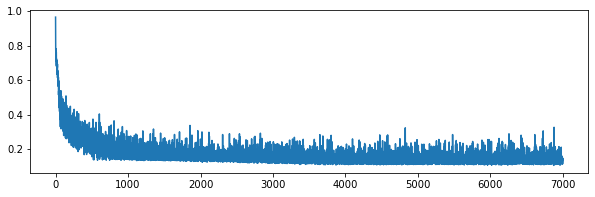

idx 1
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx0/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.005600788024366041 0.043625157713158
std_all 0.03788749658116691 0.07804370079536307
mean_all -0.0009763419373707322 0.01205825689189547
std_all 0.022028384135019854 0.020426989557159117
mean_all 0.0023122230434976547 0.03217285551544688
std_all 0.02995794035809338 0.05759269424151908
[0.33488039 0.4209617  0.47179607 0.50426293 0.53165856 0.55147799
 0.56722336 0.58269246 0.5974695  0.61087175 0.62262603 0.63333847
 0.64393611 0.65359177 0.66310817 0.67210128 0.68047974 0.68877795
 0.69650775 0.70405539]
(81, 81)
[0.17419188 0.24733301 0.28856518 0.32284099 0.35115296 0.3734402
 0.39210432 0.41027358 0.42826796 0.44484576 0.46085123 0.47396193
 0.48631876 0.49860307 0.51058112 0.52244632 0.53407046 0.54520196
 0.55573556 0.56618401]
(81, 81)
[0.25403616 0.33243247 0.37322463 0.4086357  0.438661   0.45811147
 0.47620331 0.49346898 0.50946573 0.52460207 0.53864211

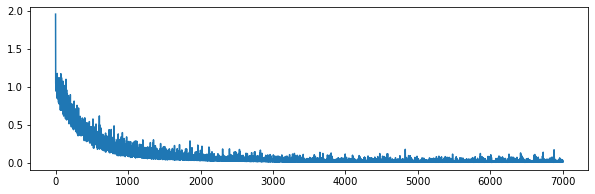

idx 2
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx0/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0012208157125696527 0.022715233101050895
std_all 0.07056940727344452 0.08144494924149077
mean_all 9.529808275330975e-05 0.01084972510239094
std_all 0.03031346754973226 0.013418236654671713
mean_all 0.0006580568976614812 0.017809151363836012
std_all 0.050441437411588394 0.06173977313446075
[0.28895105 0.39285806 0.47100552 0.53543394 0.57398556 0.60847062
 0.64245494 0.67152703 0.69866047 0.72138785 0.74338478 0.76275361
 0.77882199 0.79427789 0.8080976  0.8205024  0.8323917  0.84401816
 0.85441693 0.86432807]
(81, 81)
[0.21791333 0.30789138 0.38685226 0.46221382 0.50886056 0.55292451
 0.58847865 0.62317003 0.65287155 0.67947381 0.70548962 0.72764932
 0.74785107 0.76735874 0.78350824 0.79711706 0.80974901 0.82194272
 0.8333453  0.84368481]
(81, 81)
[0.24140739 0.33946632 0.42068364 0.49159444 0.53336665 0.57288527
 0.60580947 0.63494517 0.66315275 0.68976655 

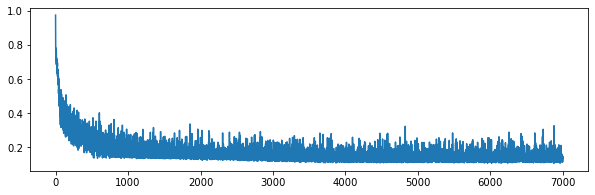

idx 3
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx0/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.004651963936023955 0.04681453625651595
std_all 0.03954223965791265 0.07584770081028383
mean_all -0.0002915108410227468 0.012206988586778548
std_all 0.022816929836187827 0.01985702596342258
mean_all 0.0021802265475006034 0.0342989092152071
std_all 0.031179584747050237 0.05606711688964714
[0.33512563 0.42835817 0.48139153 0.51737542 0.55044866 0.5757637
 0.59747427 0.61475993 0.63041141 0.64521694 0.65736413 0.66852525
 0.67954937 0.68968371 0.69912524 0.70852651 0.7173549  0.72540888
 0.7328349  0.74016274]
(81, 81)
[0.17839376 0.26158306 0.30711202 0.3464944  0.38027649 0.40957877
 0.43159544 0.4517129  0.47143508 0.48989327 0.50791926 0.52318516
 0.53712149 0.55041746 0.56327884 0.57563868 0.58700369 0.59795324
 0.60866509 0.6191224 ]
(81, 81)
[0.25204798 0.34253638 0.38739846 0.42678501 0.4619438  0.48941619
 0.51076879 0.52974936 0.54835493 0.56511025 0.57

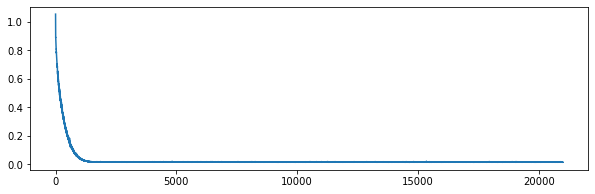

idx 12
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx3/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00035595424535427006 0.011182086603594899
std_all 0.03948463212393948 0.019721872468211426
mean_all -0.0003095170236206593 0.00850211537962667
std_all 0.03680956501410109 0.009323554831555069
mean_all 2.3218610866805382e-05 0.009938472034062793
std_all 0.03814709856902029 0.01548319928778415
[0.23617074 0.35061706 0.46257172 0.57120098 0.63440609 0.68730955
 0.72406434 0.75906783 0.79341587 0.81851761 0.83606808 0.85249534
 0.86740591 0.87711989 0.88626596 0.8939881  0.90128809 0.90723144
 0.91219946 0.91701483]
(81, 81)
[0.16052296 0.2505998  0.33878589 0.4122363  0.46967735 0.52039776
 0.5594326  0.59570168 0.63147132 0.66235857 0.69296365 0.72171024
 0.74518674 0.76353764 0.77973802 0.79502007 0.80892876 0.82230416
 0.83319416 0.84360545]
(81, 81)
[0.19772662 0.29891739 0.39685299 0.48817333 0.54780323 0.59910664
 0.63565243 0.67036513 0.70415094 0.72976028 

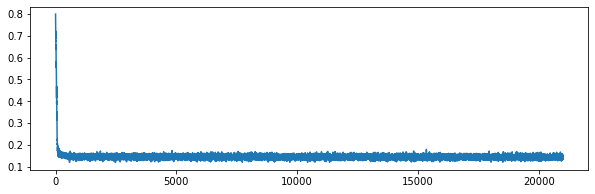

idx 13
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx3/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.000879417377379912 0.013970351496982641
std_all 0.011940270245579733 0.00765376931828431
mean_all -2.601944399455061e-05 0.011531079810974393
std_all 0.012033295924528441 0.006038634667397201
mean_all 0.00042669896669268075 0.012816911298652589
std_all 0.011986783085054088 0.0068938240589774815
[0.4840761  0.5276838  0.55962988 0.58076018 0.59215052 0.60212414
 0.61131974 0.62040526 0.62888895 0.63606385 0.64296383 0.64977239
 0.65636842 0.66289216 0.6692967  0.67542785 0.68151826 0.68753444
 0.69345314 0.69928403]
(81, 81)
[0.3563211  0.4033606  0.44330202 0.4746396  0.48911847 0.50069731
 0.51178349 0.52255715 0.53307485 0.54247804 0.55116144 0.55969376
 0.56795933 0.57616542 0.5841634  0.59197135 0.59968597 0.60713637
 0.61458341 0.62186447]
(81, 81)
[0.41993141 0.46466764 0.5004257  0.52717825 0.53993822 0.55078395
 0.56082242 0.57048457 0.5797305  0.5885591

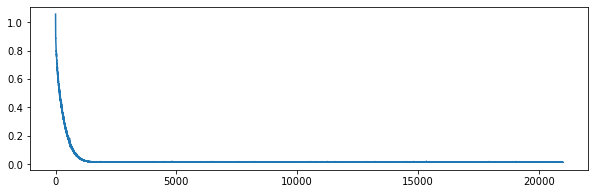

idx 14
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx3/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00030756402489836855 0.011329296167292094
std_all 0.03935844510980146 0.01928031961237093
mean_all -0.00030983436386994875 0.008416047731126676
std_all 0.03644720103288722 0.009373903740594974
mean_all -1.1351694857901012e-06 0.009984322747288587
std_all 0.037902823071344335 0.015228894686266623
[0.23667417 0.35118931 0.4634466  0.57212771 0.63533028 0.68806398
 0.72476605 0.75972173 0.79400922 0.81907614 0.83659721 0.8529931
 0.86784968 0.87750553 0.88661418 0.89431963 0.90160438 0.90756102
 0.91251672 0.9173241 ]
(81, 81)
[0.16064271 0.25067274 0.33877531 0.41227992 0.46970545 0.52042805
 0.55947124 0.59572441 0.63149826 0.6623805  0.69299767 0.72174805
 0.74523775 0.76358331 0.77977298 0.79504171 0.80894022 0.82230405
 0.83319274 0.84360561]
(81, 81)
[0.19806956 0.29916513 0.39700662 0.48869162 0.54830132 0.59952021
 0.63604901 0.67072646 0.70449415 0.73

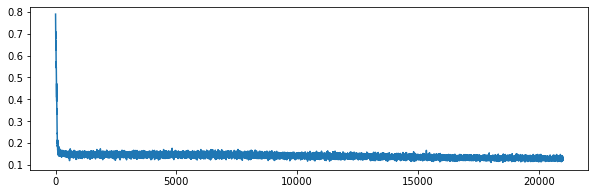

idx 15
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx3/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.00010982487196968009 0.017754156407961928
std_all 0.01422768791175735 0.00793163658728646
mean_all -0.0010980461183832872 0.014460070350316318
std_all 0.014680347930894195 0.008307148592425468
mean_all -0.0004941106232068034 0.016202363723530292
std_all 0.01445401792132577 0.008124716217686625
[0.38018982 0.47917831 0.52939627 0.576813   0.6231955  0.65277979
 0.67831076 0.69923304 0.7189804  0.73574927 0.75152726 0.76635924
 0.77892947 0.79105612 0.79984657 0.80767757 0.81507542 0.82224163
 0.82902852 0.83562658]
(81, 81)
[0.30688037 0.39042876 0.43931738 0.48355076 0.5206378  0.54879286
 0.57481868 0.59747872 0.61946976 0.63875748 0.65501448 0.67037334
 0.68527016 0.6995534  0.71354674 0.72708953 0.73725104 0.74659976
 0.75570815 0.76470808]
(81, 81)
[0.34350232 0.434557   0.48373777 0.52849038 0.57014537 0.59872846
 0.62469823 0.64621929 0.66734425 0.6854

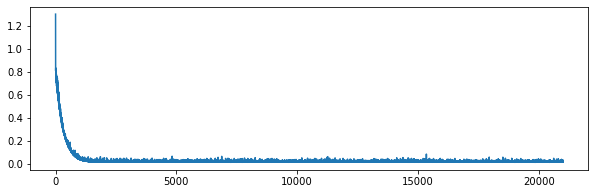

idx 16
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx4/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00025380139595353955 0.013200012451853767
std_all 0.046017604817922095 0.027648172639176412
mean_all -0.000795954741164348 0.008708952248109657
std_all 0.034235600198037355 0.012781075990218847
mean_all -0.0002710766726054042 0.011194578419097727
std_all 0.040126602507979725 0.022329186843512063
[0.19625134 0.29501748 0.38935993 0.48046265 0.53186383 0.58167013
 0.61804939 0.64845067 0.67782345 0.70280119 0.72683192 0.74964549
 0.76724452 0.78309624 0.7965378  0.80944611 0.82200654 0.83208915
 0.84137422 0.85050847]
(81, 81)
[0.19079808 0.2792452  0.36223371 0.43780329 0.49675077 0.54697937
 0.58297348 0.61703797 0.64940079 0.67964836 0.70902041 0.73651715
 0.75876561 0.77608274 0.79066499 0.80478867 0.81843249 0.82988384
 0.84004654 0.84963343]
(81, 81)
[0.1963343  0.28939604 0.37583172 0.46116233 0.51563882 0.56548833
 0.60167024 0.63343074 0.66384639 0.69106

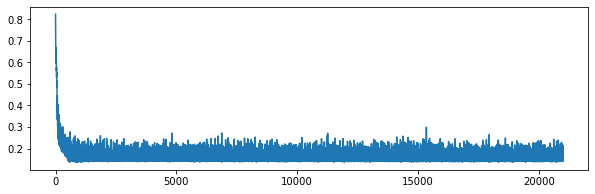

idx 17
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx4/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0012371952468685113 0.017125904335459997
std_all 0.020783815187689333 0.030120437491586573
mean_all -0.0018350787474516006 0.010750210435696166
std_all 0.019078849281265818 0.0179531810765062
mean_all -0.0002989417502915445 0.014380247867598913
std_all 0.019931332234477576 0.02480938249756962
[0.39779954 0.45366431 0.49113536 0.52390997 0.55311928 0.57381981
 0.59261357 0.60919931 0.62425442 0.63762504 0.64989002 0.66030643
 0.67044296 0.68020909 0.68969163 0.69875676 0.70763806 0.71564172
 0.72350415 0.73103781]
(81, 81)
[0.24272684 0.30125611 0.33069555 0.35766435 0.38076202 0.39995632
 0.41813027 0.4352227  0.45174172 0.4664689  0.47959708 0.49246233
 0.5050296  0.5168535  0.52855597 0.53961192 0.55033794 0.56076762
 0.57044138 0.57992642]
(81, 81)
[0.32305538 0.38041539 0.41312664 0.44261098 0.46839043 0.48827664
 0.50611601 0.52352777 0.53946289 0.553483   

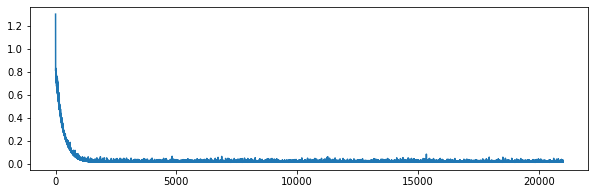

idx 18
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx4/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 8.617940309528689e-05 0.01301581788136425
std_all 0.046127433218342756 0.024261799966671903
mean_all -0.0008451433587482486 0.00839954072515302
std_all 0.03336569186485165 0.011944127984008391
mean_all -0.0003794819778264808 0.010963518608496758
std_all 0.03974656254159721 0.02015847405072958
[0.1964058  0.29511871 0.39107872 0.48221102 0.53376641 0.58373807
 0.62010519 0.65043499 0.67974501 0.70466612 0.72873282 0.75164555
 0.76924874 0.78500544 0.79844391 0.81124901 0.82369859 0.8337238
 0.84294483 0.8520096 ]
(81, 81)
[0.19006288 0.27806304 0.36097722 0.43633632 0.49525988 0.54550917
 0.58157612 0.61572256 0.64818115 0.67851523 0.70794572 0.73552696
 0.75786093 0.7752857  0.78991745 0.80413205 0.81779204 0.82918225
 0.83939154 0.84903755]
(81, 81)
[0.19593421 0.2887863  0.37523906 0.4611989  0.51579888 0.56569903
 0.60195031 0.63372183 0.66416253 0.6914061

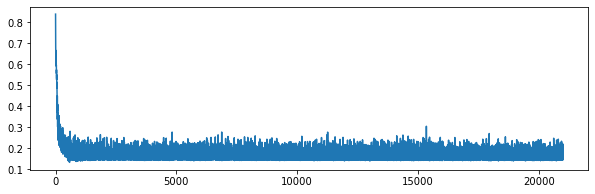

idx 19
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx4/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0011055887022993031 0.017576614144194
std_all 0.019635312420855644 0.021169201011452633
mean_all -0.0013219485054677097 0.011081694836968152
std_all 0.018315657265297457 0.020578093738206966
mean_all -0.00010817990158420323 0.014742587861042475
std_all 0.01897548484307655 0.020886164777509004
[0.39852382 0.46486278 0.50359255 0.53607702 0.56483934 0.58603485
 0.60534163 0.62300057 0.63754651 0.65172008 0.66486635 0.67537352
 0.68551975 0.69555791 0.70514021 0.71397324 0.7226534  0.73080132
 0.73848343 0.7460193 ]
(81, 81)
[0.25167825 0.31029973 0.34105789 0.36843756 0.39118726 0.41136616
 0.43083841 0.44778257 0.46385988 0.47862359 0.49184716 0.50447163
 0.51697371 0.52906061 0.5409863  0.55197088 0.56243863 0.57278195
 0.5825408  0.59180839]
(81, 81)
[0.32659541 0.38889372 0.42337873 0.4531075  0.47858648 0.49924476
 0.51816641 0.53559886 0.55068096 0.56550

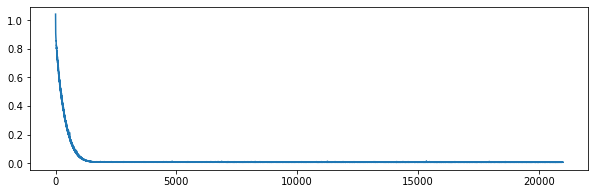

idx 20
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx5/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00012661701007098355 0.011186574028892922
std_all 0.042732565620723306 0.028099596705002994
mean_all -2.1482016994906556e-05 0.008143796116091631
std_all 0.03555971749380112 0.009308568317988722
mean_all -5.6527014686932215e-05 0.009269837067536466
std_all 0.037950666869441846 0.01823171281719852
[0.24643157 0.36263634 0.47359951 0.57870881 0.63591347 0.68387692
 0.71439465 0.74422159 0.7672355  0.78787452 0.80072379 0.81272537
 0.82278806 0.83092283 0.83888535 0.84551087 0.85174964 0.85746975
 0.86280561 0.86804645]
(81, 81)
[0.15074738 0.22585318 0.29479617 0.35575161 0.40064509 0.43835464
 0.47055918 0.50007453 0.52727179 0.55204146 0.57570448 0.59903702
 0.61984472 0.63508359 0.64859449 0.66170645 0.67376904 0.68577567
 0.69626196 0.70615147]
(81, 81)
[0.18177758 0.26928812 0.35108488 0.42498331 0.47305021 0.51339708
 0.54364789 0.57029139 0.59596433 0.619

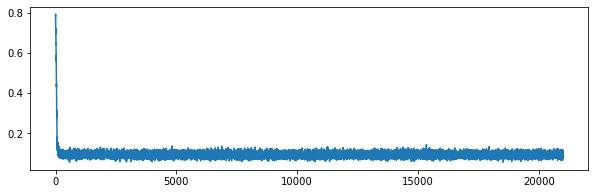

idx 21
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx5/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0011081096380711486 0.01199004949798551
std_all 0.01257591968316061 0.004357534441409781
mean_all 0.0004944735845689766 0.011857846781213018
std_all 0.012349220225295545 0.003899992619806579
mean_all 0.0006990189357363673 0.01190559224820694
std_all 0.012424786711250567 0.00405964912440971
[0.34828773 0.41749458 0.46199891 0.49029859 0.5066361  0.51821402
 0.52847739 0.53832911 0.547773   0.55689668 0.56485244 0.57275812
 0.58055855 0.58805903 0.59544929 0.60272249 0.60985359 0.61681491
 0.62373036 0.63058304]
(81, 81)
[0.34681199 0.39623416 0.43460441 0.46733462 0.48337718 0.49544775
 0.50679228 0.51772693 0.52799384 0.5373189  0.54638501 0.55516759
 0.56378667 0.57233347 0.58077936 0.58856141 0.59612646 0.60366713
 0.61091248 0.61810325]
(81, 81)
[0.34653409 0.40140211 0.44171855 0.47522739 0.49124881 0.5029772
 0.51382872 0.52438053 0.53458291 0.54370107 0.55

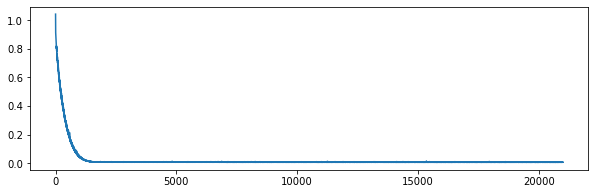

idx 22
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx5/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0001819543875391308 0.010835493445935531
std_all 0.0411254976315724 0.02778597234151728
mean_all -7.2129547817277635e-06 0.007848186995986278
std_all 0.034028527141284355 0.009454102835893966
mean_all -6.546009903419544e-05 0.008955749602792043
std_all 0.03639418397138037 0.01811443598582412
[0.24616625 0.36280356 0.47435138 0.57992658 0.63751079 0.68579301
 0.71656816 0.74659858 0.77001909 0.79102528 0.80407484 0.81623717
 0.82640579 0.83454568 0.84248397 0.84907222 0.85530015 0.86097425
 0.86626105 0.87145995]
(81, 81)
[0.1498825  0.22505707 0.29424327 0.35600875 0.40140221 0.43949703
 0.47206556 0.50174694 0.52925271 0.55423679 0.57832425 0.60201811
 0.62328547 0.63874151 0.65247276 0.66575854 0.67795994 0.69009966
 0.70066163 0.71066957]
(81, 81)
[0.1811523  0.26891287 0.35111264 0.42580662 0.47436695 0.51510661
 0.54565861 0.57267983 0.59870935 0.6222

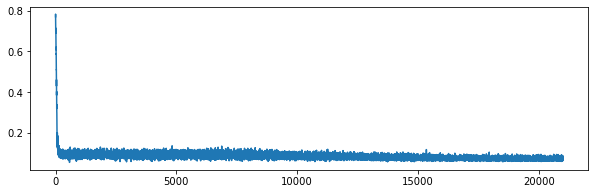

idx 23
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx5/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0007565494037075628 0.013162281597152483
std_all 0.022444069338740557 0.012920451577790513
mean_all 0.00016102868176951486 0.011846587110829934
std_all 0.021866122694702568 0.011484522822287053
mean_all 0.00035953558908219754 0.01230400123462835
std_all 0.02205877157604856 0.011985397774433644
[0.23027561 0.34612131 0.42109192 0.49143772 0.5525313  0.59025884
 0.62003296 0.64408716 0.66475671 0.68384019 0.70225037 0.71883303
 0.73343033 0.74599318 0.75595432 0.76521021 0.77440887 0.78346327
 0.79144946 0.79867228]
(81, 81)
[0.17952589 0.27585246 0.32973732 0.37864289 0.42362929 0.45473304
 0.47949638 0.50415469 0.52612868 0.54740821 0.56587998 0.58384191
 0.60118972 0.61718337 0.63226482 0.64611889 0.65819967 0.66984482
 0.68102233 0.69130273]
(81, 81)
[0.1951713  0.29881683 0.35836726 0.41321479 0.46306913 0.49538712
 0.52115896 0.54613881 0.56810552 0.5887

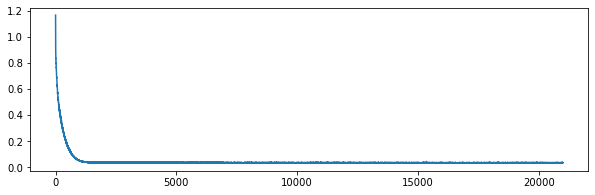

idx 24
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx6/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00040163199236778577 0.012864546377737188
std_all 0.05403462725017386 0.020107325799762012
mean_all -0.00015813703012470585 0.008819922332411068
std_all 0.04527535508416634 0.008657676827956776
mean_all -0.0002798845112462458 0.011029896381041696
std_all 0.0496549911671701 0.016087609258591096
[0.11766417 0.17500121 0.23134587 0.28575499 0.32003094 0.35084771
 0.3802437  0.40523724 0.42923797 0.45098141 0.47098726 0.49029078
 0.50808791 0.52473581 0.54049729 0.55600155 0.57076702 0.58508791
 0.59908987 0.61284307]
(81, 81)
[0.12318039 0.18926004 0.25402243 0.31392133 0.35905905 0.39670407
 0.42802105 0.45598002 0.48232251 0.50695774 0.53126043 0.55387911
 0.57345259 0.58862651 0.60252867 0.61549601 0.62809698 0.64045331
 0.65172505 0.66217744]
(81, 81)
[0.12036121 0.18125194 0.24070668 0.29896735 0.33844257 0.37243465
 0.40271858 0.42848291 0.45309762 0.475690

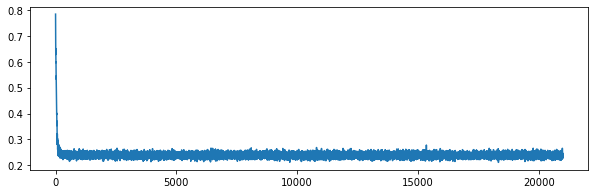

idx 25
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx6/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.00017062409880555111 0.012653846396660492
std_all 0.012954553960611225 0.005579904354293567
mean_all 0.0005011966453747218 0.008488085910407108
std_all 0.012195565494860186 0.004540908280461582
mean_all 0.00033591037209013635 0.010775483055459788
std_all 0.012575059727735706 0.005101137733888413
[0.35513268 0.41061541 0.45534513 0.4916865  0.50972876 0.52301039
 0.53533146 0.5458654  0.55608401 0.56510258 0.57404568 0.5825688
 0.59102331 0.59943047 0.60750967 0.61523366 0.62267302 0.62987496
 0.63700652 0.6440274 ]
(81, 81)
[0.24946298 0.29459485 0.333578   0.36874001 0.39040843 0.40416273
 0.41756546 0.43053344 0.44228907 0.45381882 0.46504103 0.47587718
 0.48618814 0.49607336 0.50576405 0.51529435 0.52446659 0.53344602
 0.54238981 0.5511919 ]
(81, 81)
[0.30087094 0.35117498 0.39276906 0.43079955 0.45054059 0.46345148
 0.47579468 0.487837   0.49899227 0.5092535

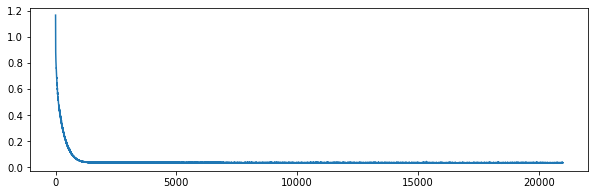

idx 26
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx6/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.00031461533028236235 0.012797527578253858
std_all 0.0539891953165278 0.019707143727533974
mean_all -0.00015612279006489477 0.008783410082054039
std_all 0.04508168044496 0.008629653588284538
mean_all -0.00023536906017362856 0.010975827183596435
std_all 0.04953543788074391 0.01585109374057631
[0.11816997 0.17630174 0.23270517 0.28710496 0.32146222 0.35232392
 0.38188652 0.40688135 0.43091881 0.45268628 0.47267705 0.49195305
 0.50973959 0.52639742 0.54218117 0.55768885 0.57244968 0.58676347
 0.60077285 0.61451935]
(81, 81)
[0.12320819 0.18931399 0.25408579 0.31393857 0.35911044 0.39676441
 0.42804975 0.45600463 0.48235536 0.50696175 0.53128551 0.55390833
 0.57347439 0.58864474 0.60254726 0.61551379 0.62811753 0.64047272
 0.65175348 0.66220558]
(81, 81)
[0.1206486  0.18153873 0.24098504 0.29963942 0.33916488 0.37318035
 0.4035386  0.42929956 0.45393177 0.47652

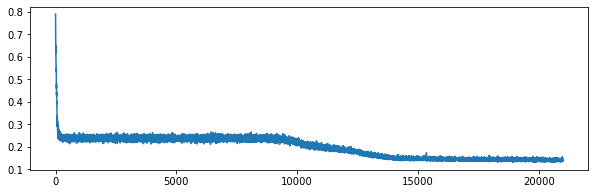

idx 27
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx6/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -4.9186541568342505e-05 0.008386281963388188
std_all 0.020547605874023652 0.007622792224270575
mean_all -9.359909836540294e-05 0.005895012621611675
std_all 0.022302587028097363 0.00896846930573481
mean_all -7.139281996687272e-05 0.007248513130843167
std_all 0.021425096451060506 0.00836900180451302
[0.15068126 0.22858781 0.28077453 0.33015701 0.37557826 0.40570209
 0.43096976 0.45549659 0.47920627 0.4990632  0.51798415 0.53679211
 0.55401013 0.57045957 0.58551445 0.59997071 0.61403944 0.6266954
 0.63920524 0.6513984 ]
(81, 81)
[0.13286778 0.20111088 0.2656446  0.32861158 0.37088792 0.40669378
 0.44104261 0.467971   0.49298704 0.51614686 0.5385239  0.55966721
 0.57991581 0.59758314 0.61150684 0.62442707 0.63653428 0.64803961
 0.65922166 0.67020725]
(81, 81)
[0.14044518 0.21256632 0.27043965 0.32637317 0.36694826 0.40280337
 0.43194366 0.45705196 0.48061603 0.502

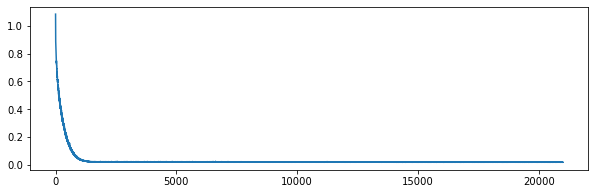

idx 28
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx7/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00022445031349183292 0.012724682259679753
std_all 0.0543575219367291 0.017443132585715462
mean_all -0.00017333549567758187 0.008882536051650522
std_all 0.05061699704587183 0.0064711801254071525
mean_all 2.555740890712551e-05 0.010974882734992392
std_all 0.05248725949130047 0.013287866831208734
[0.09616354 0.1433841  0.18794881 0.23076318 0.26076571 0.28752423
 0.31286812 0.33781752 0.3624425  0.3838408  0.40418432 0.42439872
 0.44413802 0.46362129 0.48192029 0.49918907 0.51519553 0.53055352
 0.54572978 0.56046047]
(81, 81)
[0.06467392 0.10081729 0.13403201 0.16591768 0.19173938 0.21427029
 0.23592014 0.25602242 0.27584971 0.29451359 0.31161882 0.32828193
 0.34430531 0.35950973 0.37456141 0.38932455 0.40392176 0.41823572
 0.43240237 0.4461059 ]
(81, 81)
[0.08032246 0.12177517 0.16055057 0.19749598 0.22286938 0.24789116
 0.27031959 0.29257281 0.31395785 0.3333131

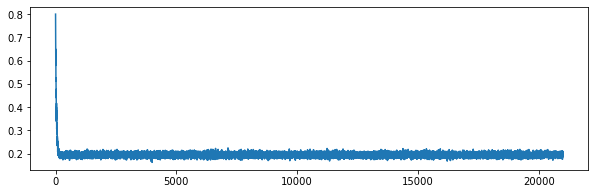

idx 29
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx7/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0022398690208153887 0.01119160459942689
std_all 0.014603226811890411 0.0037225995634462853
mean_all 0.0005243634741878264 0.008565506769808747
std_all 0.013950818731498758 0.003224739189340745
mean_all 0.001382116247501608 0.01000228472334715
std_all 0.014277022771694585 0.0034978213576968625
[0.28309505 0.35010854 0.40455337 0.43796238 0.45995739 0.47446924
 0.48813273 0.50092567 0.51258393 0.52376513 0.5345597  0.54464017
 0.55438474 0.56371721 0.57291524 0.58188814 0.59066655 0.59911027
 0.60732918 0.61550735]
(81, 81)
[0.21406403 0.2797597  0.32975996 0.37604935 0.40134921 0.41985719
 0.43646544 0.45237566 0.46666449 0.48057568 0.49380027 0.50587347
 0.51745063 0.52840226 0.53893676 0.54911417 0.55925911 0.56900452
 0.57855248 0.58805345]
(81, 81)
[0.24875614 0.31464834 0.36500381 0.40849408 0.43202423 0.44828613
 0.46324542 0.47705907 0.49041954 0.50310977 

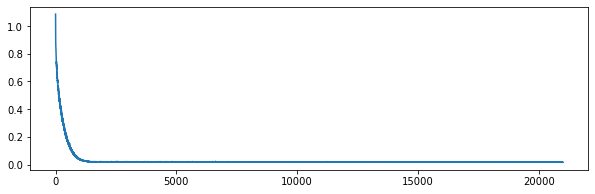

idx 30
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx7/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0002444487472637696 0.012772559208419125
std_all 0.05434754604131363 0.01821413529566377
mean_all -0.00017313130944357507 0.008872527222583016
std_all 0.05053885543431453 0.006471646639414067
mean_all 3.565871891009727e-05 0.01099879981179603
std_all 0.05244320073781408 0.013800181101422289
[0.09618784 0.14343289 0.18802529 0.23098091 0.26101882 0.28778316
 0.31312754 0.3380881  0.36272828 0.38412956 0.40448357 0.42470346
 0.44446372 0.46394429 0.4822513  0.49952897 0.51553804 0.53091111
 0.54608229 0.56080916]
(81, 81)
[0.06471587 0.10087772 0.13411566 0.1660102  0.19186166 0.21439446
 0.23605811 0.25616548 0.27600974 0.29468225 0.31179619 0.32846441
 0.34449809 0.35971576 0.37476896 0.3895456  0.40415086 0.41847308
 0.43263517 0.44634371]
(81, 81)
[0.08035462 0.12182556 0.16062579 0.19764995 0.22304387 0.24808545
 0.27052029 0.29278615 0.31418203 0.333541

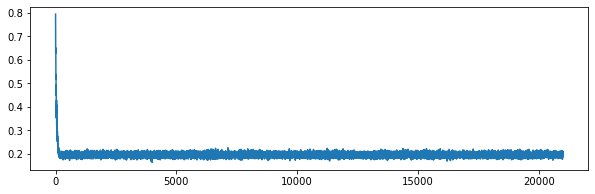

idx 31
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx7/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0030139657467441387 0.015631721767079176
std_all 0.018709181667280472 0.004094896604735853
mean_all 0.0013618200393933563 0.011302399038349642
std_all 0.01743472157668236 0.003697887701520097
mean_all 0.002187892893068747 0.013664913869919242
std_all 0.018071951621981414 0.003953142795156436
[0.32840921 0.38200873 0.42460562 0.46398911 0.48881789 0.50530639
 0.5205968  0.5343989  0.54723904 0.55950555 0.57137267 0.58216219
 0.59272793 0.60256317 0.61230443 0.6219685  0.63080171 0.63952081
 0.64807985 0.65660799]
(81, 81)
[0.2372397  0.29797052 0.35088744 0.39528867 0.42459931 0.44810962
 0.46683716 0.48467727 0.50170569 0.51820849 0.53366198 0.5475383
 0.56078849 0.57346407 0.58570672 0.59650916 0.60716234 0.61774991
 0.62804831 0.63824049]
(81, 81)
[0.28195967 0.33947312 0.38719336 0.43048981 0.45744071 0.4773556
 0.49371753 0.50922697 0.52450461 0.53914338

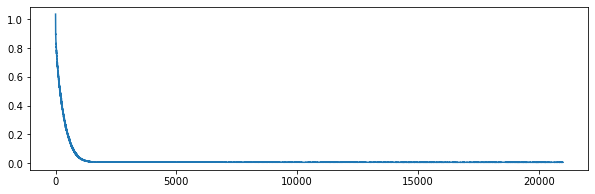

idx 32
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx8/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00017628123451364193 0.011445526189288987
std_all 0.05646028550058746 0.007404052195194712
mean_all -8.560753563364351e-05 0.00823502181442434
std_all 0.048643200332363766 0.005238681293222938
mean_all 1.6887210821183143e-06 0.009428272413975765
std_all 0.05124889538843833 0.007081558977245152
[0.07117683 0.10829249 0.144171   0.17518985 0.20307168 0.23001595
 0.25530345 0.28024525 0.30492383 0.32725257 0.349217   0.37055656
 0.39149388 0.41176296 0.4317606  0.45066675 0.46906142 0.48719271
 0.50412425 0.52040843]
(81, 81)
[0.04731122 0.07659564 0.10139111 0.12575352 0.14777956 0.16899266
 0.19008925 0.21047229 0.23013487 0.24956944 0.26869542 0.28760781
 0.30608791 0.32444104 0.34234424 0.35979035 0.37701946 0.39393401
 0.41071589 0.42731585]
(81, 81)
[0.055091   0.08689857 0.11530593 0.14176023 0.16534824 0.18807816
 0.21023791 0.23167502 0.25264017 0.2730794

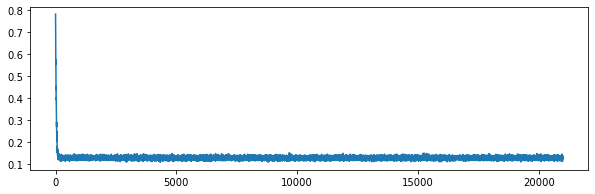

idx 33
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx8/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0008267036199700801 0.01066248850548649
std_all 0.015024800298374271 0.0037338945656804467
mean_all 0.001515537147085869 0.007902542049901155
std_all 0.013815083582268763 0.003274277933845636
mean_all 0.0007347902247338858 0.00898603355901286
std_all 0.014218322487637264 0.0034813488905198605
[0.26461082 0.34103846 0.4046054  0.4535614  0.48050588 0.4998926
 0.51592995 0.53051707 0.5425944  0.55378619 0.5647436  0.57555828
 0.58617017 0.59594516 0.60549792 0.61468722 0.6237904  0.63247955
 0.64078166 0.64867341]
(81, 81)
[0.18825903 0.25808237 0.31298804 0.35483298 0.38310305 0.40258982
 0.42110938 0.4361609  0.45063247 0.46472446 0.47864155 0.49062176
 0.50247096 0.5139113  0.52526624 0.53603887 0.54647891 0.55640001
 0.56614556 0.57570186]
(81, 81)
[0.21602651 0.2874029  0.34088976 0.38902398 0.41671308 0.43597351
 0.45312484 0.4683698  0.48212738 0.49512052 

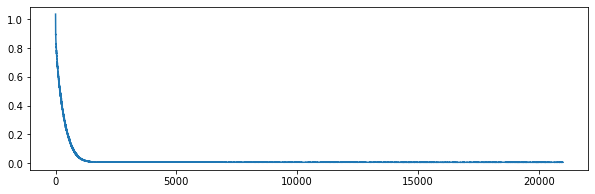

idx 34
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx8/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.0001833526551479485 0.01142258359153279
std_all 0.05634572092921625 0.0073771568380206565
mean_all -8.630958574615639e-05 0.008213708811421755
std_all 0.04851397742436697 0.005234134666327712
mean_all 3.5778278852118977e-06 0.009406627437893363
std_all 0.05112455859265009 0.007073555886549746
[0.07140085 0.10854129 0.14445192 0.1754633  0.20336358 0.23032295
 0.25559699 0.28053232 0.30520006 0.32751877 0.34948661 0.37081726
 0.39175272 0.41201728 0.43202046 0.45092935 0.46931756 0.48743525
 0.50436266 0.52064186]
(81, 81)
[0.04732843 0.07662135 0.10142358 0.12579341 0.1478226  0.16903854
 0.19014643 0.21054853 0.23021317 0.24965218 0.26878635 0.28770339
 0.30618626 0.3245456  0.34244835 0.35989948 0.37713438 0.39405141
 0.41083824 0.4274436 ]
(81, 81)
[0.05517058 0.08699295 0.11541998 0.14187549 0.16547014 0.18820861
 0.21036833 0.23180811 0.25277236 0.2732

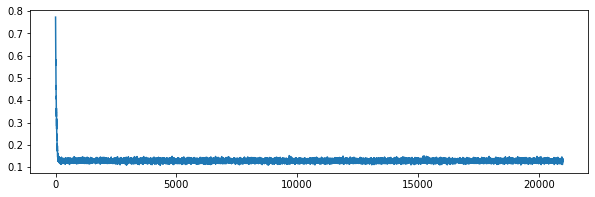

idx 35
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx8/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all -0.0010141338381444275 0.01348811401613773
std_all 0.01766417727004522 0.0049972502873865164
mean_all 0.0019620480394619538 0.010233383124104822
std_all 0.015867856269146916 0.004299296431616984
mean_all 0.0009699874135931597 0.01150765811324721
std_all 0.01646662993611302 0.004622105922416962
[0.29770636 0.36380832 0.42036277 0.47330064 0.50270647 0.52287875
 0.54042048 0.55744559 0.57183015 0.58449788 0.59704768 0.60844087
 0.61935176 0.62982612 0.63977182 0.64955082 0.65918352 0.66861236
 0.67712331 0.68538831]
(81, 81)
[0.22414208 0.2887802  0.34791762 0.38993828 0.42062774 0.44337579
 0.46366215 0.48005507 0.49610074 0.51168281 0.52706213 0.54002795
 0.55235834 0.56427317 0.57613132 0.58749612 0.59806123 0.60814061
 0.61805614 0.62764245]
(81, 81)
[0.25065771 0.31485057 0.37287315 0.41887902 0.44897391 0.46987687
 0.48999864 0.50628237 0.52144181 0.536346

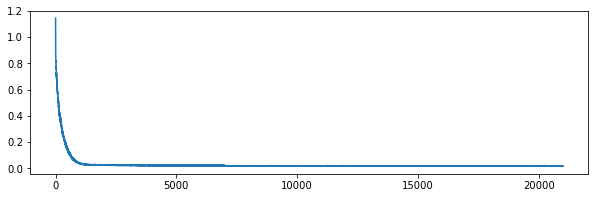

idx 36
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx9/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all 0.00014566940282413894 0.013850569145914891
std_all 0.0635316799008943 0.007613239980467394
mean_all -0.00015554681637885311 0.008912242441574148
std_all 0.0546938246043936 0.0059106840596818006
mean_all -4.938706777357094e-06 0.011647139060913641
std_all 0.05911275225264395 0.008122544311190501
[0.05664282 0.095113   0.1329206  0.16564917 0.19790598 0.22952801
 0.26094685 0.29023205 0.3189157  0.34627213 0.37108285 0.39570206
 0.41989214 0.44334719 0.46532241 0.48656666 0.5072016  0.52703104
 0.54611595 0.56478189]
(81, 81)
[0.04987168 0.07907275 0.10428721 0.12807913 0.15169023 0.17443112
 0.19665336 0.21852171 0.23968011 0.26072117 0.2816718  0.30195328
 0.32218586 0.34194638 0.36148888 0.38089512 0.39951241 0.41774646
 0.43588319 0.45376854]
(81, 81)
[0.05285772 0.08487541 0.11485252 0.14311096 0.17029158 0.19683428
 0.22290681 0.24890794 0.2737711  0.2977653

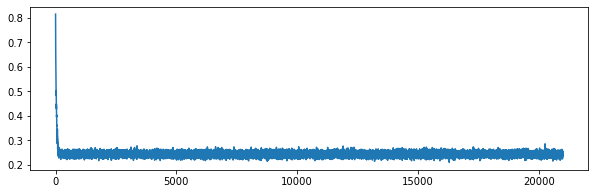

idx 37
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx9/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 6.278654979572443e-05 0.009941708324697561
std_all 0.014697166363932625 0.0032740966175465376
mean_all 0.0018767244714442332 0.007025019200217032
std_all 0.013297400459758944 0.0029015702107832103
mean_all 0.0009697555106199789 0.00865545043797768
std_all 0.013997283411845782 0.003171631334374928
[0.25584647 0.32623997 0.38503698 0.4331628  0.45912196 0.47894101
 0.49572343 0.51013583 0.52357669 0.53645116 0.54921656 0.56149058
 0.57246074 0.58283576 0.59294484 0.60295856 0.61233055 0.62161932
 0.6303095  0.63883061]
(81, 81)
[0.16537439 0.22140025 0.27490465 0.31068965 0.33537104 0.35795983
 0.37946743 0.39643691 0.4125959  0.42792983 0.44265073 0.45646134
 0.46960068 0.48258713 0.49408616 0.50549129 0.51649101 0.52733687
 0.53807639 0.5481439 ]
(81, 81)
[0.21197998 0.27507088 0.3312906  0.37310213 0.39842836 0.41887437
 0.43833488 0.4531836  0.46782604 0.4820723

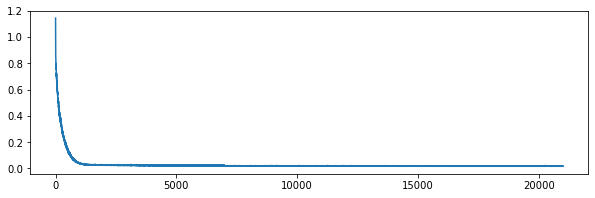

idx 38
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx9/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all 8.220499158460167e-05 0.013868399848565667
std_all 0.06359608615161416 0.01006004578061465
mean_all -0.00015229334172297307 0.008886005899962302
std_all 0.05458332867711747 0.0058996262678411154
mean_all -3.5044175069185696e-05 0.011647341111773603
std_all 0.05908970741436584 0.009397473326786076
[0.05611847 0.09440148 0.13210392 0.16476741 0.19697389 0.22857945
 0.25997815 0.28925776 0.31792162 0.34522617 0.37003875 0.3946283
 0.41881656 0.44224033 0.4642275  0.48545252 0.50611861 0.52597018
 0.54504851 0.56372846]
(81, 81)
[0.04939011 0.07856127 0.10356674 0.12737344 0.1510119  0.17372179
 0.19594666 0.21782177 0.2389924  0.26002311 0.28093602 0.30119254
 0.32139395 0.34115261 0.36067618 0.38004308 0.39867694 0.41685555
 0.43500835 0.45286645]
(81, 81)
[0.05234689 0.08424384 0.1141429  0.14239548 0.16957148 0.19608208
 0.22215437 0.24810396 0.27292914 0.296

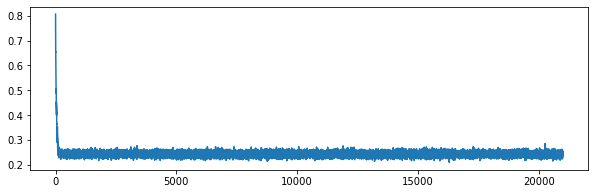

idx 39
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx9/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 6.765344809241982e-05 0.01120849940482384
std_all 0.015701276947651496 0.004848845221597083
mean_all 0.001861788922621719 0.007898938982812222
std_all 0.014058423798350308 0.004017455694475239
mean_all 0.0009647211853570695 0.009737380474558062
std_all 0.014879850373000904 0.004527733068278253
[0.2746688  0.34225633 0.40243576 0.44799559 0.47506915 0.49529723
 0.51379091 0.52857874 0.54254831 0.55608308 0.56947376 0.58182671
 0.5932033  0.60374276 0.61412202 0.62412159 0.63369444 0.64284079
 0.65155866 0.66012628]
(81, 81)
[0.18139125 0.23865522 0.29304251 0.3300849  0.3557634  0.38024524
 0.40218864 0.41991368 0.43654865 0.45227745 0.46728724 0.48145455
 0.49491211 0.5077642  0.51934018 0.53077512 0.54165814 0.55246157
 0.56324198 0.57322396]
(81, 81)
[0.22898117 0.2913141  0.34881387 0.38989351 0.41628833 0.43778072
 0.45842415 0.47403599 0.48912467 0.503834

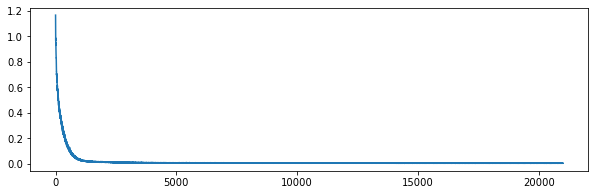

idx 40
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx10/actrelu/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0007103697059151772 0.022051644736241043
std_all 0.05547894763536657 0.007814031970876479
mean_all -0.0005738190581113264 0.010651517283744659
std_all 0.04577970577254982 0.007500176094233362
mean_all -0.0006420943820132518 0.017316743040465297
std_all 0.05062932670395819 0.009065025743016335
[0.11869356 0.19067174 0.25524981 0.30917916 0.35657075 0.40002981
 0.43588657 0.47073322 0.50197217 0.53128914 0.55431631 0.57701852
 0.59923112 0.61797211 0.63507358 0.65179288 0.6670666  0.68203035
 0.69619107 0.71005586]
(81, 81)
[0.06024171 0.11165352 0.15564755 0.1968773  0.23772454 0.27693306
 0.31382078 0.34915785 0.38293012 0.41597904 0.4450459  0.47381592
 0.50207623 0.52764696 0.5519987  0.57503401 0.59563211 0.61591515
 0.63569381 0.65423171]
(81, 81)
[0.08383991 0.14974148 0.20078016 0.24530795 0.28730421 0.32911142
 0.36713113 0.40335403 0.43690302 0.469424

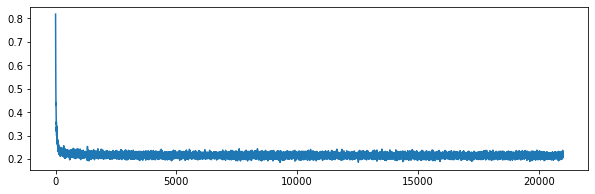

idx 41
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx10/actrelu/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0029030761313447806 0.007348779439686146
std_all 0.01727107850649859 0.010137752849602314
mean_all 0.0004162224398226605 0.0067921051533119175
std_all 0.015697417484579826 0.009014084177198631
mean_all 0.0016596492855837199 0.007184339646352987
std_all 0.01648424799553921 0.00962460261255486
[0.11673121 0.21350797 0.27043237 0.29919898 0.32261413 0.34262296
 0.36211423 0.3790014  0.39485585 0.40998337 0.42421077 0.4379561
 0.45164279 0.46490025 0.47785429 0.49019565 0.50223515 0.51399111
 0.52507146 0.5359019 ]
(81, 81)
[0.13069856 0.22327653 0.27893233 0.31110026 0.33943076 0.36411014
 0.38526423 0.404558   0.4228413  0.43978534 0.45627076 0.47150286
 0.4854728  0.49910727 0.51190344 0.52378301 0.5355807  0.54697953
 0.55817144 0.56883923]
(81, 81)
[0.12922879 0.22320079 0.27878452 0.3094352  0.33389557 0.35783121
 0.37884676 0.3976051  0.41497865 0.4308277  0

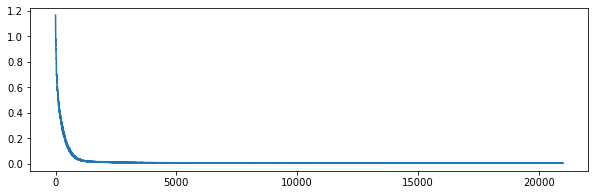

idx 42
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx10/actsoftplus/lossmse/k9/bn_preTrue/model_seed0
mean_all -0.0007251050336719169 0.022062600577620804
std_all 0.055549444463762275 0.007823851944549343
mean_all -0.0005777040555093825 0.010653807928677884
std_all 0.045773251392614726 0.00750527304374211
mean_all -0.0006514045445906497 0.01732444560661286
std_all 0.050661347928188494 0.009091995330881092
[0.11854463 0.19042936 0.25498667 0.30891466 0.35633182 0.39978162
 0.43566563 0.47051187 0.50176854 0.53112022 0.55416902 0.57686637
 0.59910313 0.61786421 0.63495638 0.65168197 0.66696964 0.68195078
 0.69612497 0.71000736]
(81, 81)
[0.06023892 0.11178557 0.15581857 0.19705842 0.23792299 0.27716899
 0.31405199 0.34938883 0.38319934 0.41624006 0.44533045 0.47411565
 0.50236309 0.5279365  0.55228164 0.5752999  0.59589597 0.6161701
 0.63594697 0.65452022]
(81, 81)
[0.08380616 0.14966402 0.20070446 0.24524806 0.28727046 0.32907782
 0.3671074  0.40334975 0.43690919 0.46

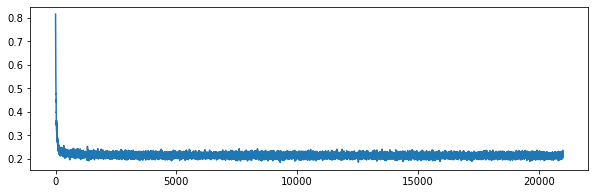

idx 43
key imagenet_val+first500+everything/PredNetBpE_3CLS_sep2/baseidx10/actsoftplus/lossl1/k9/bn_preTrue/model_seed0
mean_all 0.0035425730560206753 0.008998016260243782
std_all 0.018906265106118196 0.010675203085258763
mean_all 0.0002766885841760822 0.008430192432469763
std_all 0.016689369061488494 0.009566635174742908
mean_all 0.0019096308200983788 0.008870328115684327
std_all 0.017797817083803343 0.010196513706029475
[0.14696974 0.24477543 0.30163269 0.33191207 0.35578364 0.37662828
 0.39711805 0.41444028 0.43089081 0.44575339 0.46012671 0.47387523
 0.48753259 0.50057719 0.51352647 0.52589816 0.53784499 0.54908023
 0.55978212 0.57032288]
(81, 81)
[0.16528915 0.25733433 0.31487005 0.34685588 0.37634891 0.4012091
 0.42213068 0.44147654 0.45991007 0.47635136 0.49239928 0.50727811
 0.52104478 0.53414609 0.54634541 0.55806354 0.5695954  0.58067544
 0.59126441 0.6013639 ]
(81, 81)
[0.16390604 0.25738863 0.31370228 0.34566481 0.37056464 0.39498472
 0.41701592 0.43554591 0.45304    0.4684

In [10]:
collect_all()